In [45]:
import tensorflow as tf
from tensorflow import keras 
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix
from keras.applications import MobileNetV2
import os

# HYPER PARAMETERS


In [46]:


BACH_SIZE=4
N_EPOCHS=100
LR=1e-4
PATH="D:\\df\\ai\\obd\\hand sign dataset"
columns=["path","width","height","label","x1","y1","x2","y2"]
LABELS=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
IMAGE_WIDTH=256
IMAGE_HEIGHT=256
N_CLASSES=len(LABELS)
CSV_PATH="history.csv"
MODEL_SAVE="D:\\df\\ai\\models\\asl_obj"


# Data Preprocessing


In [47]:

#load data paths
def load_data(path,classes,train=True):
    images=[]
    bboxes=[]
    labels=[]
    

    if train :
        df=pd.read_csv(os.path.join(path,"train_labels.csv"),names=columns,header=1)
    else :
        df=pd.read_csv(os.path.join(path,"test_labels.csv"),names=columns,header=1)

    for _ , row in df.iterrows():
        label=row["label"]
        image=os.path.join(path,"images",row["path"])
        
        images.append(image)
        bboxes.append([int(row["x1"]),int(row["y1"]),int(row["x2"]),int(row["y2"])])
        labels.append(LABELS.index(label))

    return images,bboxes,labels

#split_dataset
def load_dataset(path,classes):
    train_images,train_bboxes,train_labels=load_data(path,classes)
    images,bboxes,labels=load_data(path,classes,False)

    test_images,val_images=train_test_split(images,test_size=0.5,random_state=18,shuffle=True)
    test_bboxes,val_bboxes=train_test_split(bboxes,test_size=0.5,random_state=18,shuffle=True)
    test_labels,val_labels=train_test_split(labels,test_size=0.5,random_state=18,shuffle=True)


    return (train_images,train_bboxes,train_labels),(val_images,val_bboxes,val_labels),(test_images,test_bboxes,test_labels)

#load images as numpy data
def read_images(image_path,bbox,label):
    image=tf.io.read_file(image_path)
    image=tf.io.decode_jpeg(image)
    height,width,channels=image.shape
    image=tf.image.resize(image,(IMAGE_HEIGHT,IMAGE_WIDTH),tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    if channels==1:
        image=tf.image.grayscale_to_rgb(image)
    image=np.array(image,dtype=np.float32)
    image=2*(image/255)-1
    
  
    
    # bbox
    x1,y1,x2,y2=bbox
    x1=x1/width
    x2=x2/width
    y1=y1/height
    y2=y2/height
    bbox=np.array([x1,y1,x2,y2],dtype=np.float32)

    
    #one hot encoding label
    one_hot=np.zeros(N_CLASSES,dtype=np.float32)
    one_hot[label]=1
    

    return image,bbox,one_hot

#load dataset as tensors
def load_tensors(images,bboxes,labels):
    images,bboxes,labels=tf.numpy_function(read_images,[images,bboxes,labels],[tf.float32,tf.float32,tf.float32])
    return images,(bboxes,labels)

def tfData(images,bbox,labels,test=False):
    ds=tf.data.Dataset.from_tensor_slices((images,bbox,labels))
    ds=ds.map(load_tensors,num_parallel_calls=tf.data.AUTOTUNE)
    ds=ds.cache()
    if not test:
        ds=ds.batch(BACH_SIZE)
    ds=ds.prefetch(tf.data.AUTOTUNE)
    return ds


(train_images,train_bboxes,train_labels),(val_images,val_bboxes,val_labels),(test_images,test_bboxes,test_labels)=load_dataset(PATH,LABELS)

ds_train=tfData(train_images,train_bboxes,train_labels)
ds_val=tfData(val_images,val_bboxes,val_labels)
print(f"train     : {len(train_images)}")
print(f"validatin : {len(val_images)}")
print(f"test      : {len(test_images)}")

train     : 1511
validatin : 36
test      : 35


# Build Model

In [4]:
def asl_model():
    
    input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3)
    inputs = layers.Input(input_shape)

    pretrain = MobileNetV2(include_top=False,weights="imagenet",input_tensor=inputs)
    pretrain.trainable = True
    

    
    x = pretrain.output
    x = layers.Conv2D(256, kernel_size=1, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    bbox = layers.Dense(4, activation="sigmoid", name="bbox")(x)
    label = layers.Dense(N_CLASSES, activation="softmax", name="label")(x)

    
    model = tf.keras.models.Model(inputs=[inputs], outputs=[bbox, label])
    return model
    

model=asl_model()
model.summary()
model.compile(
        
       loss = {
            "bbox": "binary_crossentropy",
            "label": "categorical_crossentropy"
        },
        optimizer=keras.optimizers.Adam(LR)
    )

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 32  128         ['Conv1[0][0]']                  
                                )                                                             

# Training

In [5]:
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping


callbacks = [
        ModelCheckpoint(MODEL_SAVE, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
        CSVLogger(CSV_PATH,append=False)
    ]

history=model.fit(
        ds_train,
        epochs=N_EPOCHS,
        validation_data=ds_val,
        verbose=1,
        callbacks=callbacks
    )

Epoch 1/100
378/378 [==============================] - ETA: 0s - loss: 3.4544 - bbox_loss: 0.5853 - label_loss: 2.8690
Epoch 1: val_loss improved from inf to 2.97061, saving model to D:\df\ai\models\asl_obj


INFO:tensorflow:Assets written to: D:\df\ai\models\asl_obj\assets


INFO:tensorflow:Assets written to: D:\df\ai\models\asl_obj\assets


378/378 [==============================] - 54s 117ms/step - loss: 3.4544 - bbox_loss: 0.5853 - label_loss: 2.8690 - val_loss: 2.9706 - val_bbox_loss: 0.5923 - val_label_loss: 2.3783 - lr: 1.0000e-04
Epoch 2/100
377/378 [============================>.] - ETA: 0s - loss: 2.1265 - bbox_loss: 0.5518 - label_loss: 1.5748
Epoch 2: val_loss improved from 2.97061 to 2.18494, saving model to D:\df\ai\models\asl_obj


INFO:tensorflow:Assets written to: D:\df\ai\models\asl_obj\assets


INFO:tensorflow:Assets written to: D:\df\ai\models\asl_obj\assets


378/378 [==============================] - 37s 98ms/step - loss: 2.1261 - bbox_loss: 0.5518 - label_loss: 1.5743 - val_loss: 2.1849 - val_bbox_loss: 0.5754 - val_label_loss: 1.6095 - lr: 1.0000e-04
Epoch 3/100
378/378 [==============================] - ETA: 0s - loss: 1.3368 - bbox_loss: 0.5494 - label_loss: 0.7873
Epoch 3: val_loss improved from 2.18494 to 1.74683, saving model to D:\df\ai\models\asl_obj


INFO:tensorflow:Assets written to: D:\df\ai\models\asl_obj\assets


INFO:tensorflow:Assets written to: D:\df\ai\models\asl_obj\assets


378/378 [==============================] - 37s 97ms/step - loss: 1.3368 - bbox_loss: 0.5494 - label_loss: 0.7873 - val_loss: 1.7468 - val_bbox_loss: 0.5613 - val_label_loss: 1.1856 - lr: 1.0000e-04
Epoch 4/100
378/378 [==============================] - ETA: 0s - loss: 0.9746 - bbox_loss: 0.5468 - label_loss: 0.4278
Epoch 4: val_loss improved from 1.74683 to 1.51228, saving model to D:\df\ai\models\asl_obj


INFO:tensorflow:Assets written to: D:\df\ai\models\asl_obj\assets


INFO:tensorflow:Assets written to: D:\df\ai\models\asl_obj\assets


378/378 [==============================] - 39s 104ms/step - loss: 0.9746 - bbox_loss: 0.5468 - label_loss: 0.4278 - val_loss: 1.5123 - val_bbox_loss: 0.5628 - val_label_loss: 0.9495 - lr: 1.0000e-04
Epoch 5/100
378/378 [==============================] - ETA: 0s - loss: 0.8297 - bbox_loss: 0.5465 - label_loss: 0.2832
Epoch 5: val_loss did not improve from 1.51228
378/378 [==============================] - 23s 59ms/step - loss: 0.8297 - bbox_loss: 0.5465 - label_loss: 0.2832 - val_loss: 1.5319 - val_bbox_loss: 0.5659 - val_label_loss: 0.9660 - lr: 1.0000e-04
Epoch 6/100
378/378 [==============================] - ETA: 0s - loss: 0.7529 - bbox_loss: 0.5433 - label_loss: 0.2097
Epoch 6: val_loss improved from 1.51228 to 1.38083, saving model to D:\df\ai\models\asl_obj


INFO:tensorflow:Assets written to: D:\df\ai\models\asl_obj\assets


INFO:tensorflow:Assets written to: D:\df\ai\models\asl_obj\assets


378/378 [==============================] - 40s 107ms/step - loss: 0.7529 - bbox_loss: 0.5433 - label_loss: 0.2097 - val_loss: 1.3808 - val_bbox_loss: 0.5645 - val_label_loss: 0.8163 - lr: 1.0000e-04
Epoch 7/100
378/378 [==============================] - ETA: 0s - loss: 0.7093 - bbox_loss: 0.5426 - label_loss: 0.1667
Epoch 7: val_loss improved from 1.38083 to 1.32534, saving model to D:\df\ai\models\asl_obj


INFO:tensorflow:Assets written to: D:\df\ai\models\asl_obj\assets


INFO:tensorflow:Assets written to: D:\df\ai\models\asl_obj\assets


378/378 [==============================] - 38s 101ms/step - loss: 0.7093 - bbox_loss: 0.5426 - label_loss: 0.1667 - val_loss: 1.3253 - val_bbox_loss: 0.5650 - val_label_loss: 0.7603 - lr: 1.0000e-04
Epoch 8/100
378/378 [==============================] - ETA: 0s - loss: 0.6836 - bbox_loss: 0.5422 - label_loss: 0.1414
Epoch 8: val_loss improved from 1.32534 to 1.16654, saving model to D:\df\ai\models\asl_obj


INFO:tensorflow:Assets written to: D:\df\ai\models\asl_obj\assets


INFO:tensorflow:Assets written to: D:\df\ai\models\asl_obj\assets


378/378 [==============================] - 40s 105ms/step - loss: 0.6836 - bbox_loss: 0.5422 - label_loss: 0.1414 - val_loss: 1.1665 - val_bbox_loss: 0.5599 - val_label_loss: 0.6066 - lr: 1.0000e-04
Epoch 9/100
378/378 [==============================] - ETA: 0s - loss: 0.6538 - bbox_loss: 0.5396 - label_loss: 0.1142
Epoch 9: val_loss did not improve from 1.16654
378/378 [==============================] - 22s 58ms/step - loss: 0.6538 - bbox_loss: 0.5396 - label_loss: 0.1142 - val_loss: 1.3474 - val_bbox_loss: 0.5578 - val_label_loss: 0.7897 - lr: 1.0000e-04
Epoch 10/100
378/378 [==============================] - ETA: 0s - loss: 0.6290 - bbox_loss: 0.5368 - label_loss: 0.0922
Epoch 10: val_loss did not improve from 1.16654
378/378 [==============================] - 23s 61ms/step - loss: 0.6290 - bbox_loss: 0.5368 - label_loss: 0.0922 - val_loss: 1.1814 - val_bbox_loss: 0.5541 - val_label_loss: 0.6273 - lr: 1.0000e-04
Epoch 11/100
377/378 [============================>.] - ETA: 0s - loss:

INFO:tensorflow:Assets written to: D:\df\ai\models\asl_obj\assets


INFO:tensorflow:Assets written to: D:\df\ai\models\asl_obj\assets


378/378 [==============================] - 39s 103ms/step - loss: 0.5637 - bbox_loss: 0.5283 - label_loss: 0.0354 - val_loss: 1.1421 - val_bbox_loss: 0.5493 - val_label_loss: 0.5928 - lr: 1.0000e-05
Epoch 17/100
378/378 [==============================] - ETA: 0s - loss: 0.5636 - bbox_loss: 0.5281 - label_loss: 0.0356
Epoch 17: val_loss improved from 1.14210 to 1.12977, saving model to D:\df\ai\models\asl_obj


INFO:tensorflow:Assets written to: D:\df\ai\models\asl_obj\assets


INFO:tensorflow:Assets written to: D:\df\ai\models\asl_obj\assets


378/378 [==============================] - 39s 102ms/step - loss: 0.5636 - bbox_loss: 0.5281 - label_loss: 0.0356 - val_loss: 1.1298 - val_bbox_loss: 0.5490 - val_label_loss: 0.5808 - lr: 1.0000e-05
Epoch 18/100
378/378 [==============================] - ETA: 0s - loss: 0.5573 - bbox_loss: 0.5271 - label_loss: 0.0302
Epoch 18: val_loss improved from 1.12977 to 1.08668, saving model to D:\df\ai\models\asl_obj


INFO:tensorflow:Assets written to: D:\df\ai\models\asl_obj\assets


INFO:tensorflow:Assets written to: D:\df\ai\models\asl_obj\assets


378/378 [==============================] - 38s 100ms/step - loss: 0.5573 - bbox_loss: 0.5271 - label_loss: 0.0302 - val_loss: 1.0867 - val_bbox_loss: 0.5491 - val_label_loss: 0.5376 - lr: 1.0000e-05
Epoch 19/100
378/378 [==============================] - ETA: 0s - loss: 0.5573 - bbox_loss: 0.5257 - label_loss: 0.0315
Epoch 19: val_loss improved from 1.08668 to 1.07950, saving model to D:\df\ai\models\asl_obj


INFO:tensorflow:Assets written to: D:\df\ai\models\asl_obj\assets


INFO:tensorflow:Assets written to: D:\df\ai\models\asl_obj\assets


378/378 [==============================] - 42s 111ms/step - loss: 0.5573 - bbox_loss: 0.5257 - label_loss: 0.0315 - val_loss: 1.0795 - val_bbox_loss: 0.5491 - val_label_loss: 0.5304 - lr: 1.0000e-05
Epoch 20/100
378/378 [==============================] - ETA: 0s - loss: 0.5550 - bbox_loss: 0.5254 - label_loss: 0.0295
Epoch 20: val_loss did not improve from 1.07950
378/378 [==============================] - 25s 65ms/step - loss: 0.5550 - bbox_loss: 0.5254 - label_loss: 0.0295 - val_loss: 1.0921 - val_bbox_loss: 0.5481 - val_label_loss: 0.5441 - lr: 1.0000e-05
Epoch 21/100
378/378 [==============================] - ETA: 0s - loss: 0.5529 - bbox_loss: 0.5246 - label_loss: 0.0283
Epoch 21: val_loss did not improve from 1.07950
378/378 [==============================] - 25s 66ms/step - loss: 0.5529 - bbox_loss: 0.5246 - label_loss: 0.0283 - val_loss: 1.0979 - val_bbox_loss: 0.5477 - val_label_loss: 0.5502 - lr: 1.0000e-05
Epoch 22/100
378/378 [==============================] - ETA: 0s - los

INFO:tensorflow:Assets written to: D:\df\ai\models\asl_obj\assets


INFO:tensorflow:Assets written to: D:\df\ai\models\asl_obj\assets


378/378 [==============================] - 41s 108ms/step - loss: 0.5534 - bbox_loss: 0.5259 - label_loss: 0.0274 - val_loss: 1.0550 - val_bbox_loss: 0.5466 - val_label_loss: 0.5084 - lr: 1.0000e-05
Epoch 23/100
378/378 [==============================] - ETA: 0s - loss: 0.5492 - bbox_loss: 0.5244 - label_loss: 0.0248
Epoch 23: val_loss did not improve from 1.05496
378/378 [==============================] - 25s 66ms/step - loss: 0.5492 - bbox_loss: 0.5244 - label_loss: 0.0248 - val_loss: 1.0686 - val_bbox_loss: 0.5465 - val_label_loss: 0.5220 - lr: 1.0000e-05
Epoch 24/100
378/378 [==============================] - ETA: 0s - loss: 0.5458 - bbox_loss: 0.5221 - label_loss: 0.0237
Epoch 24: val_loss improved from 1.05496 to 1.05177, saving model to D:\df\ai\models\asl_obj


INFO:tensorflow:Assets written to: D:\df\ai\models\asl_obj\assets


INFO:tensorflow:Assets written to: D:\df\ai\models\asl_obj\assets


378/378 [==============================] - 45s 120ms/step - loss: 0.5458 - bbox_loss: 0.5221 - label_loss: 0.0237 - val_loss: 1.0518 - val_bbox_loss: 0.5462 - val_label_loss: 0.5056 - lr: 1.0000e-05
Epoch 25/100
378/378 [==============================] - ETA: 0s - loss: 0.5467 - bbox_loss: 0.5223 - label_loss: 0.0243
Epoch 25: val_loss did not improve from 1.05177
378/378 [==============================] - 26s 68ms/step - loss: 0.5467 - bbox_loss: 0.5223 - label_loss: 0.0243 - val_loss: 1.1214 - val_bbox_loss: 0.5460 - val_label_loss: 0.5754 - lr: 1.0000e-05
Epoch 26/100
378/378 [==============================] - ETA: 0s - loss: 0.5468 - bbox_loss: 0.5221 - label_loss: 0.0247
Epoch 26: val_loss did not improve from 1.05177
378/378 [==============================] - 26s 68ms/step - loss: 0.5468 - bbox_loss: 0.5221 - label_loss: 0.0247 - val_loss: 1.1042 - val_bbox_loss: 0.5470 - val_label_loss: 0.5572 - lr: 1.0000e-05
Epoch 27/100
378/378 [==============================] - ETA: 0s - los

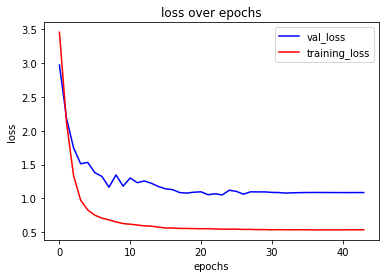

<Figure size 1440x720 with 0 Axes>

In [4]:
df=pd.read_csv("history.csv")
x=np.arange(df.shape[0])



ax=plt.subplot()
plt.figure(figsize=(20,10))
ax.set_title("loss over epochs")
ax.set_xlabel("epochs")
ax.set_ylabel("loss")
ax.plot(x,df["val_loss"],label="val_loss",c="blue")
ax.plot(x,df["loss"],label="training_loss",c="red")
ax.legend()

In [74]:
model=tf.keras.models.load_model(MODEL_SAVE)
ds_test=tfData(test_images,test_bboxes,test_labels,True)
ds_test = iter(ds_test)
labels=[]
real_bboxs=[]
preds=[]
for images,(bboxs,label) in ds_test:
    pred_bbox,pred_label=model.predict(images,verbose=0)
    preds.append(np.argmax(pred_label))
    labels.append(np.argmax(label))
print(f"accuracy score is :{accuracy_score(labels,preds)}")    
print("f1 score is       :",f1_score(labels,preds,average="macro"))

accuracy score is :0.8
f1 score is       : 0.6893939393939393
